In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import re
from scipy.fftpack import fft
import pickle
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf

from statsmodels.tsa.arima_model import ARIMA
import warnings


In [4]:
data = pd.read_csv('data/train_1.csv')

In [5]:
data.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


In [7]:
# extracting country, agent, site
# ?:foobar, foobar as a non capturing group

pat = re.compile(
    '(.+)_([a-z]{2}\.)?((?:wikipedia\.org)|(?:commons\.wikimedia\.org)|(?:www\.wikimedia\.org)|(?:www\.mediawiki\.org))_([a-z_-]+?)$'
)
print(pat.fullmatch('BLEACH_zh.wikipedia.org_all-accessspider').groups())
print(pat.fullmatch('Accueil_commons.wikimedia.org_all-access_spider').groups())


('BLEACH', 'zh.', 'wikipedia.org', 'all-accessspider')
('Accueil', None, 'commons.wikimedia.org', 'all-access_spider')


In [8]:
print(pat.fullmatch('"Keep_me_logged_in"_extended_to_one_year_www.mediawiki.org_all-access_all-agents').groups())

('"Keep_me_logged_in"_extended_to_one_year', None, 'www.mediawiki.org', 'all-access_all-agents')


In [9]:
def extract_from_url(urls):
    '''
    receives pandas dataframe column or series
    returns a pandas dataframe with all the extracted features
    '''
    
    if isinstance(urls, pd.Series):
         urls = urls.values
    
    agents = np.full_like(urls, np.NaN)
    sites = np.full_like(urls, np.NaN)
    countries = np.full_like(urls, np.NaN)
    titles = np.full_like(urls, np.nan)
    
    for i in range(len(urls)):
        url = urls[i]
        match = pat.fullmatch(url)
        assert match, "regex pattern matching failed %s" % url
        
        title = match.group(1)
        titles[i] = title
        
        country = match.group(2)
        if country:
            countries[i] = country[:-1]
        else:
            countries[i] = 'na'
            
        site = match.group(3)
        sites[i] = site
        
        agent = match.group(4)
        agents[i] = agent
        
    return pd.DataFrame({
        'page': urls,
        'title': titles,
        'agent': agents,
        'site': sites,
        'country': countries,
    })

urls = data.Page
extract = extract_from_url(urls)

In [10]:
extract.head()

,agent,country,page,site,title
0,all-access_spider,zh,2NE1_zh.wikipedia.org_all-access_spider,wikipedia.org,2NE1
1,all-access_spider,zh,2PM_zh.wikipedia.org_all-access_spider,wikipedia.org,2PM
2,all-access_spider,zh,3C_zh.wikipedia.org_all-access_spider,wikipedia.org,3C
3,all-access_spider,zh,4minute_zh.wikipedia.org_all-access_spider,wikipedia.org,4minute
4,all-access_spider,zh,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,wikipedia.org,52_Hz_I_Love_You


In [11]:
# agent country site
# day of week, pageviews (log1p), page popularity
# autocorrelation(yearly, quarterly)

def build_data(source) -> pd.Series:
    # extract features from urls
    urls = source.Page
    extracts = extract_from_url(urls)
    
    # drop page column, concat with extracts
    df = source.drop(labels='Page', axis=1)
    df = pd.concat([extracts, df])
    
    return df

df = build_data(data)

In [12]:
extract.country.value_counts()

en    24108
ja    20431
de    18547
na    17855
fr    17802
zh    17229
ru    15022
es    14069
Name: country, dtype: int64

In [13]:
extract.shape, data.shape

((145063, 5), (145063, 551))

In [14]:
data['lang'] = extract.country

In [15]:
data.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,lang
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0,zh
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0,zh
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0,zh
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0,zh
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0,zh


In [16]:
lang_sets = {}
lang_sets['en'] = data[data.lang =='en'].iloc[:, 0:-2]
lang_sets['ja'] = data[data.lang =='ja'].iloc[:, 0:-2]
lang_sets['de'] = data[data.lang =='de'].iloc[:, 0:-2]
lang_sets['fr'] = data[data.lang =='fr'].iloc[:, 0:-2]
lang_sets['zh'] = data[data.lang =='zh'].iloc[:, 0:-2]
lang_sets['ru'] = data[data.lang =='ru'].iloc[:, 0:-2]
lang_sets['es'] = data[data.lang =='es'].iloc[:, 0:-2]
lang_sets['na'] = data[data.lang =='na'].iloc[:, 0:-2]

In [17]:
sums = {}
for key in lang_sets:
    sums[key] = lang_sets[key].iloc[:, 1:].sum(axis=0) / lang_sets[key].shape[0]

In [18]:
labels={'en':'English','ja':'Japanese','de':'German',
        'na':'Media','fr':'French','zh':'Chinese',
        'ru':'Russian','es':'Spanish'
       }


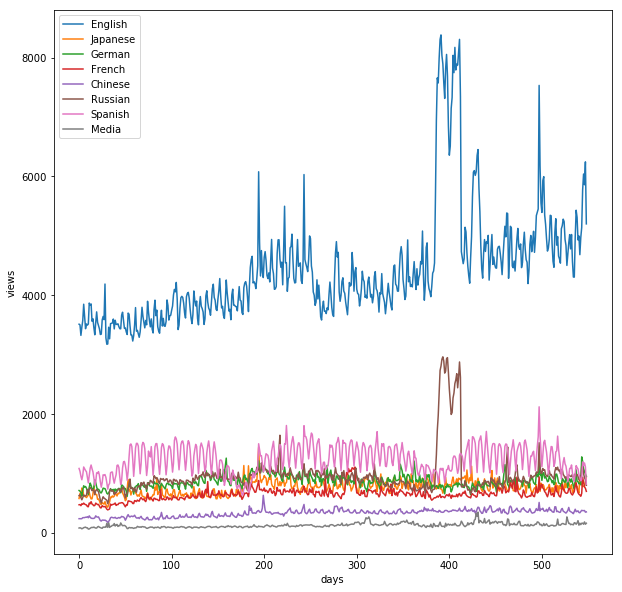

In [19]:
days = [r for r in range(sums['en'].shape[0])]

fig = plt.figure(1, figsize=[10, 10])
plt.ylabel('views')
plt.xlabel('days')


for key in sums:
    plt.plot(days, sums[key], label = labels[key])
    
plt.legend()
plt.show()

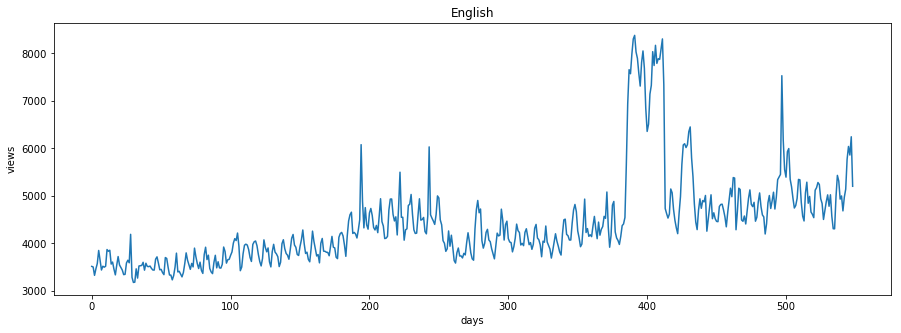

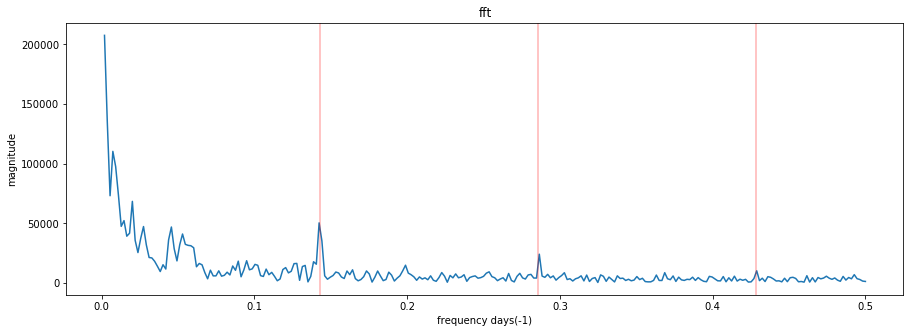

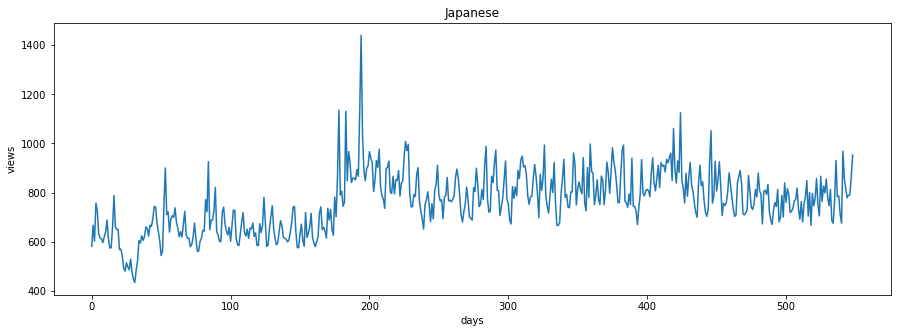

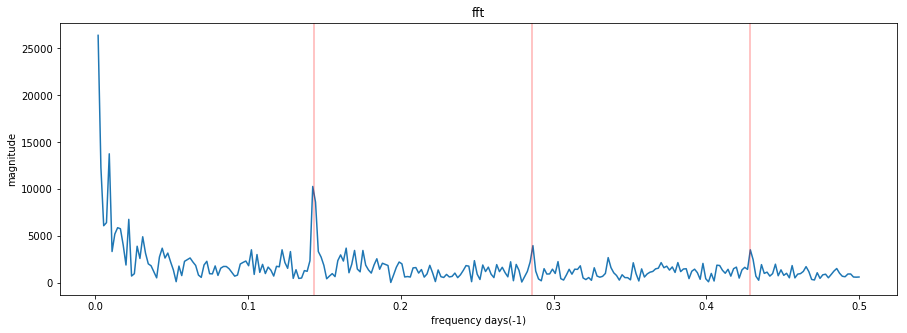

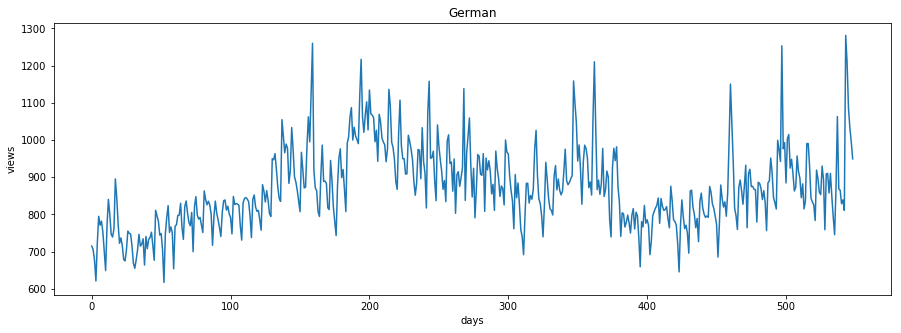

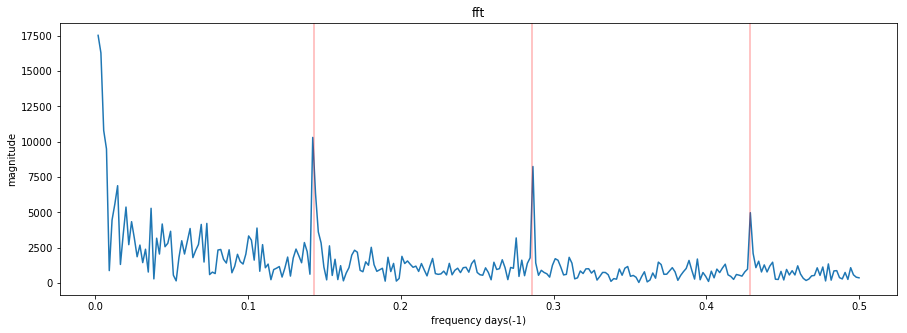

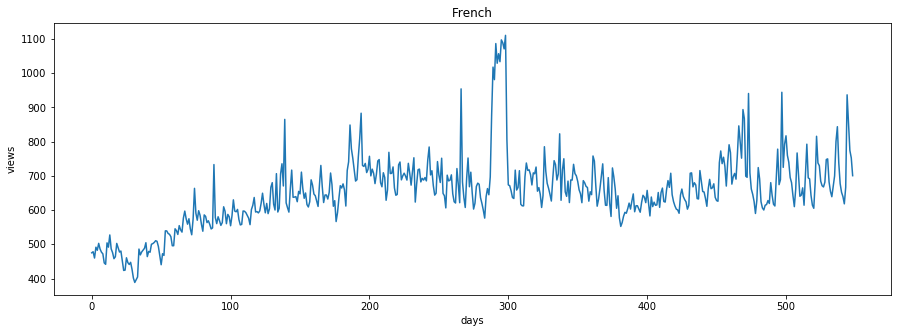

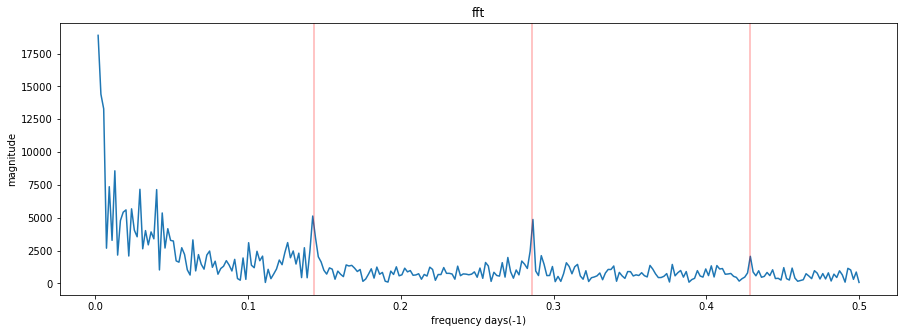

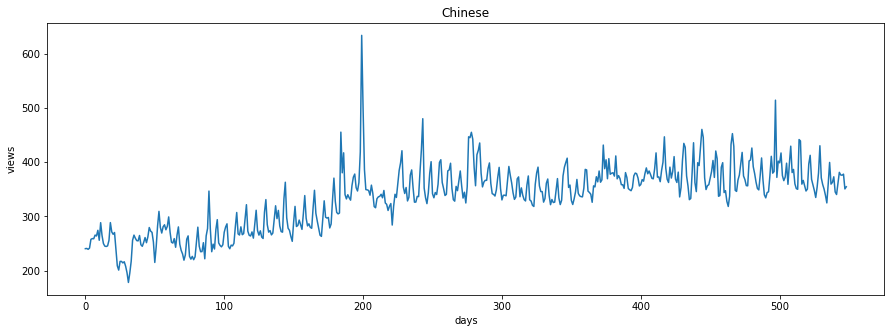

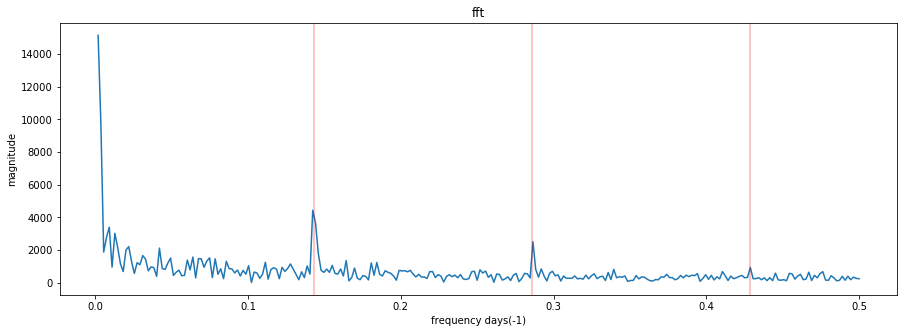

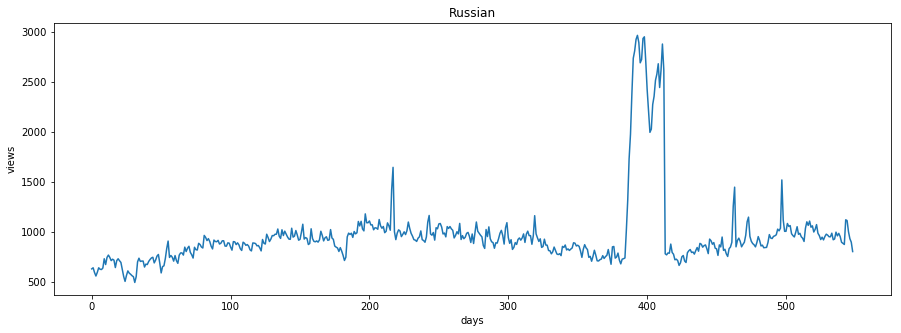

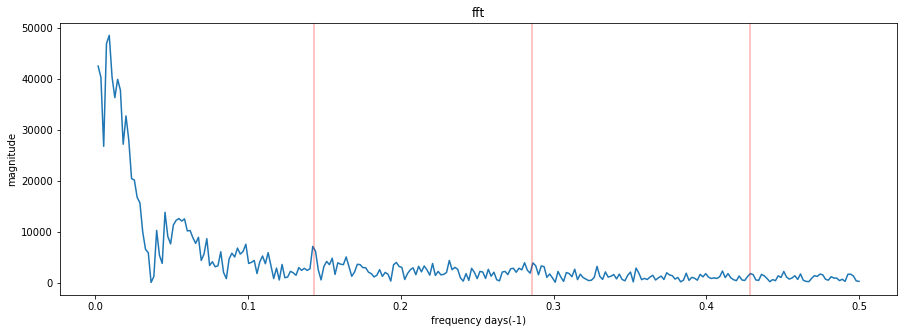

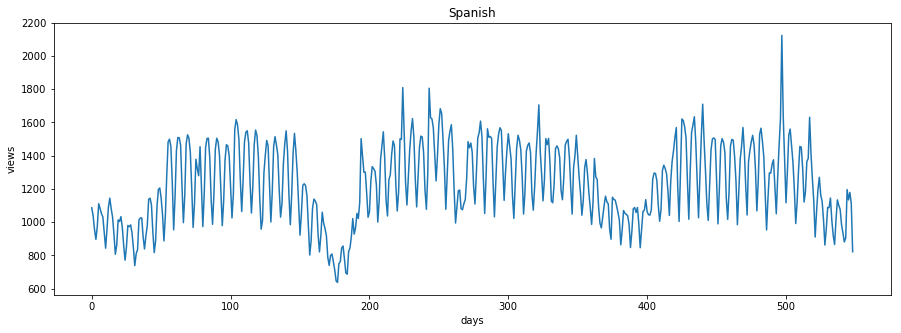

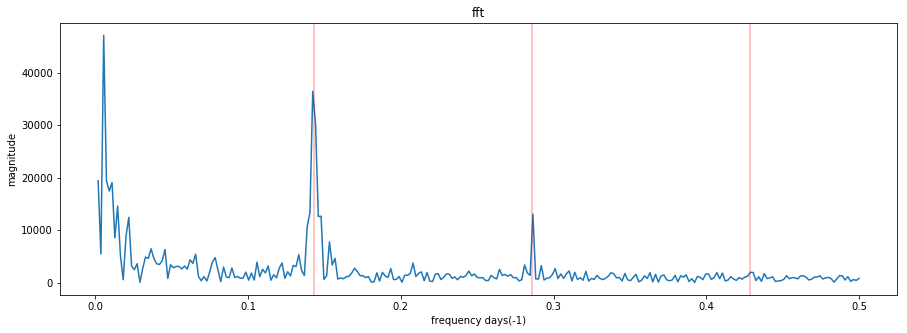

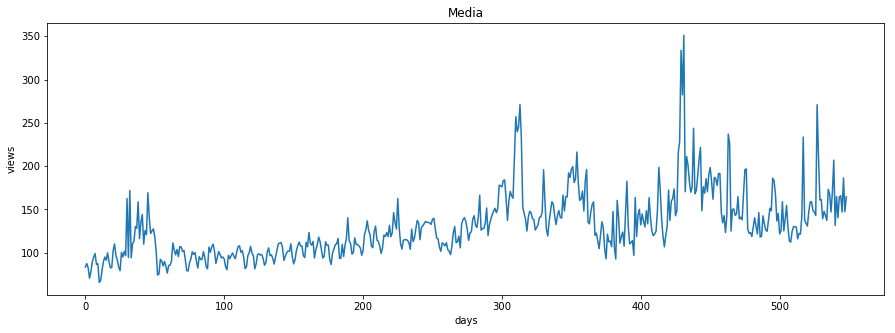

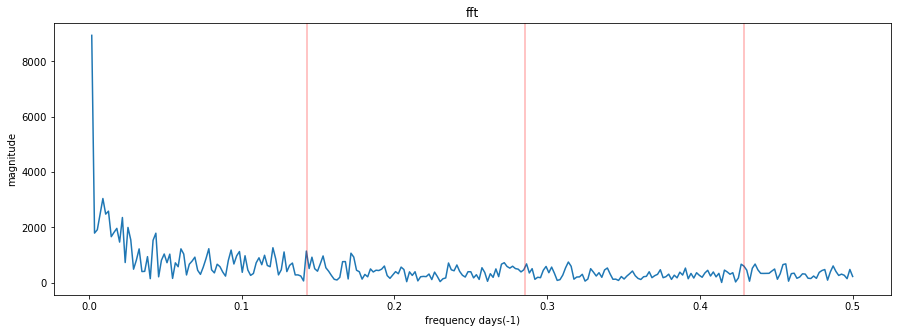

In [20]:

def plot_fft(key):
    
    fig = plt.figure(1, figsize=[15,5]) 
    plt.ylabel('views')
    plt.xlabel('days')
    plt.title(labels[key])
    plt.plot(days, sums[key], label=labels[key])
    
    fig = plt.figure(2, figsize=[15,5]) 
    fft_complex = fft(sums[key])
    fft_mag = [np.sqrt(np.real(x) * np.real(x) + np.imag(x)*np.imag(x)) 
              for x in fft_complex]
    fft_xvals = [day/ days[-1] for day in days]
    
    npts = len(fft_xvals) // 2 + 1
    fft_mag = fft_mag[:npts]
    fft_xvals = fft_xvals[:npts]
    
    plt.ylabel('magnitude')
    plt.xlabel('frequency days(-1)')
    plt.title('fft')
    plt.plot(fft_xvals[1:], fft_mag[1:], label = labels[key])
    
    plt.axvline(x=1./7, color='red', alpha=0.3)
    plt.axvline(x=2./7, color='red', alpha=0.3)
    plt.axvline(x=3./7, color='red', alpha=0.3)
    
    plt.show()
    
for key in sums:
    plot_fft(key)

In [21]:
def plot_entry(key, idx):
    article = lang_sets[key].iloc[idx, 1:]
    
    fig = plt.figure(1, figsize=(10,5))
    plt.plot(days, article)
    plt.xlabel('days')
    plt.ylabel('views')
    plt.title(data.iloc[lang_sets[key].index[idx],0])
    
    plt.show()

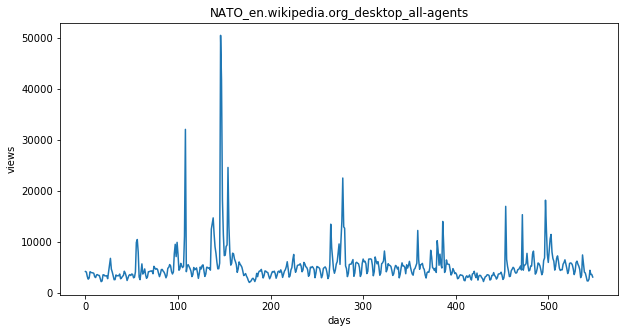

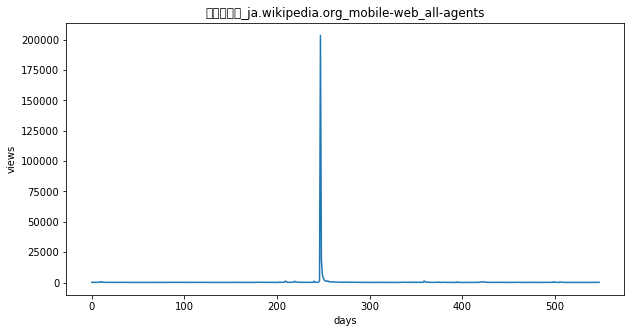

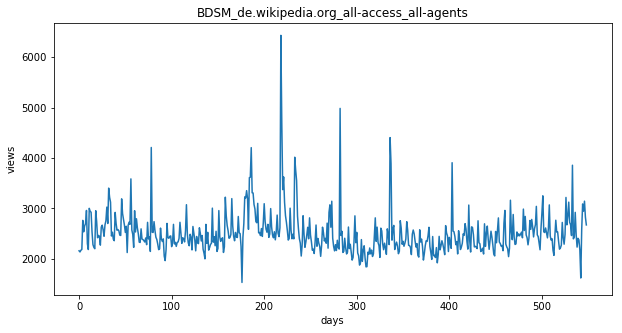

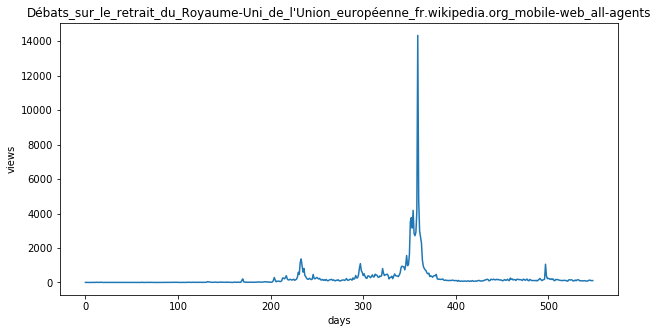

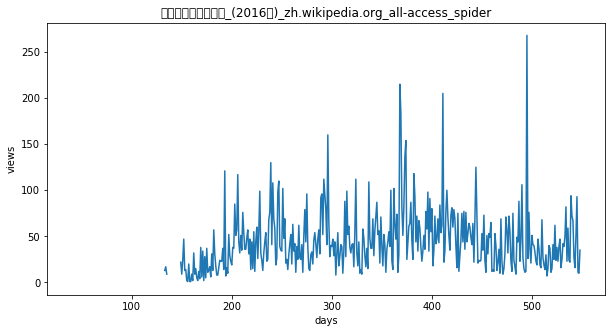

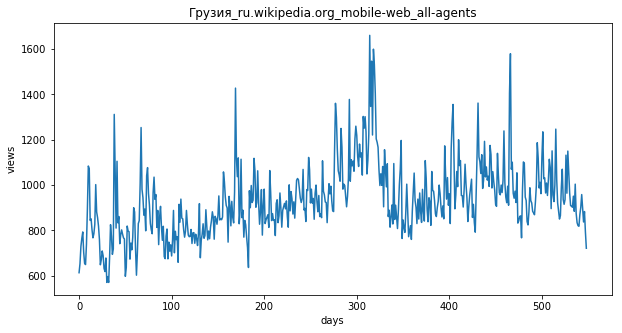

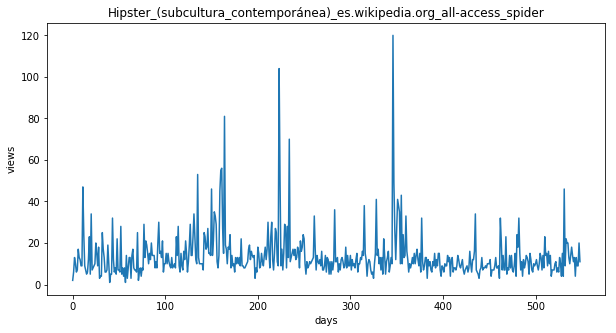

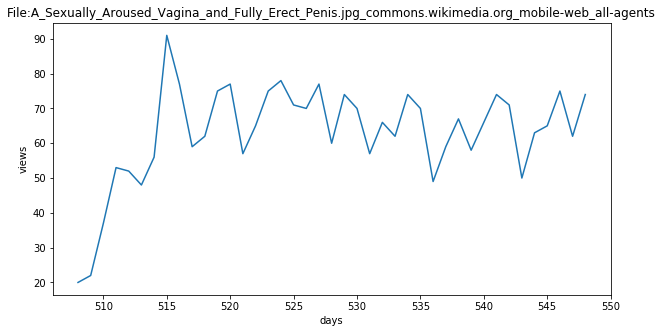

In [22]:
for key in lang_sets:
    rnd_idx = np.random.randint(lang_sets[key].shape[0])
    plot_entry(key, rnd_idx)

In [23]:
n_pages = 5
top_pages = {}

for key in lang_sets:
    print(key)
    sum_set = pd.DataFrame(lang_sets[key][['Page']])
    sum_set['total'] = lang_sets[key].sum(axis=1)
    sum_set = sum_set.sort_values('total', ascending=False)
    print(sum_set.head(10))
    top_pages[key] = sum_set.index[0]
    print('\n\n')

en
                                                    Page         total
38573   Main_Page_en.wikipedia.org_all-access_all-agents  1.204003e+10
9774       Main_Page_en.wikipedia.org_desktop_all-agents  8.754906e+09
74114   Main_Page_en.wikipedia.org_mobile-web_all-agents  3.150045e+09
39180  Special:Search_en.wikipedia.org_all-access_all...  1.302502e+09
10403  Special:Search_en.wikipedia.org_desktop_all-ag...  1.010672e+09
74690  Special:Search_en.wikipedia.org_mobile-web_all...  2.917619e+08
39172  Special:Book_en.wikipedia.org_all-access_all-a...  1.335657e+08
10399   Special:Book_en.wikipedia.org_desktop_all-agents  1.328590e+08
33644       Main_Page_en.wikipedia.org_all-access_spider  1.289433e+08
34257  Special:Search_en.wikipedia.org_all-access_spider  1.241589e+08



ja
                                                     Page        total
120336      メインページ_ja.wikipedia.org_all-access_all-agents  210254229.0
86431          メインページ_ja.wikipedia.org_desktop_all-agents  133948459

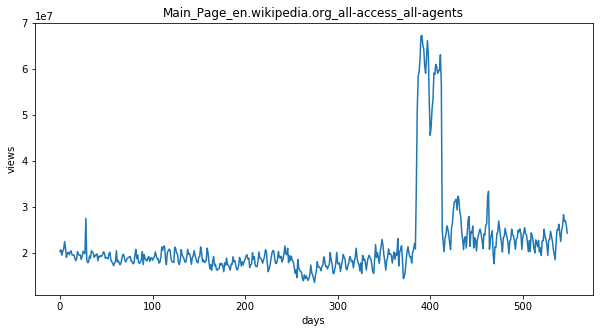

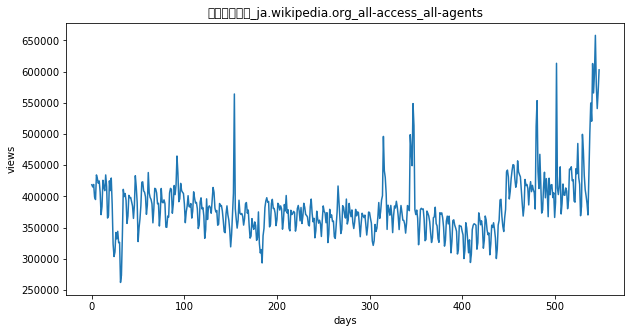

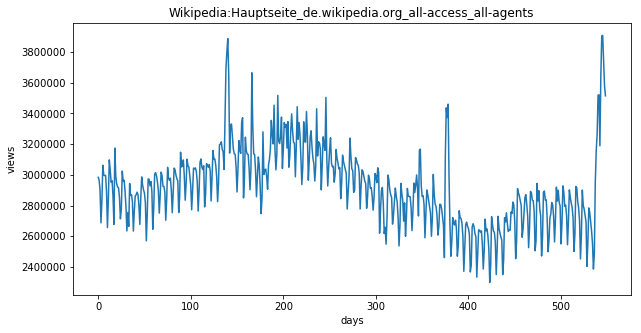

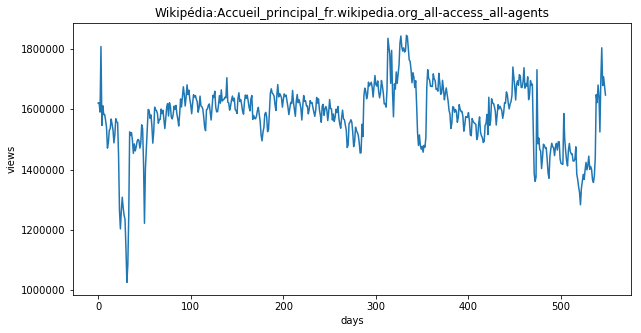

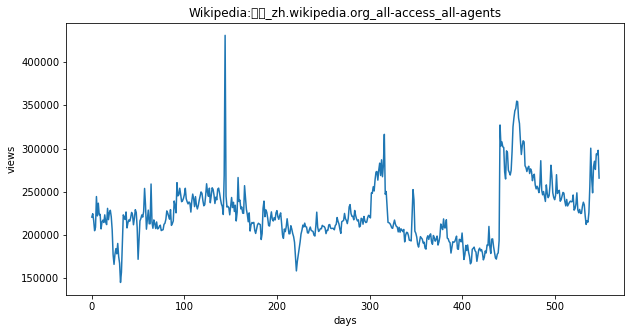

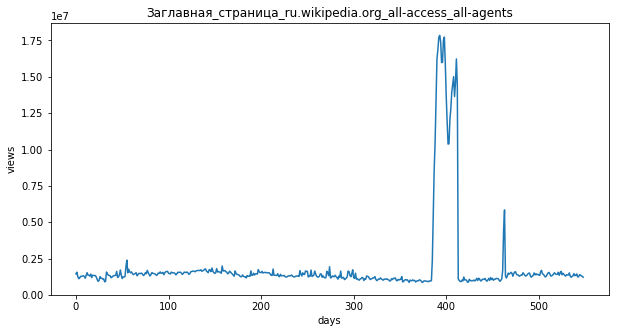

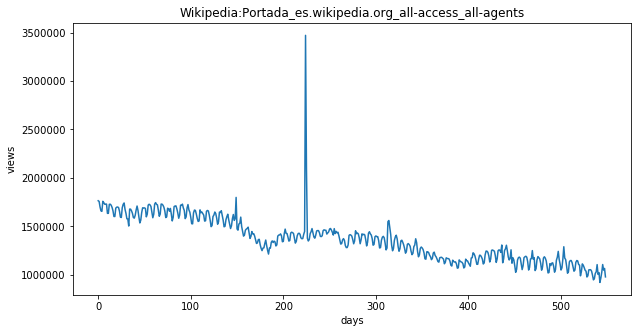

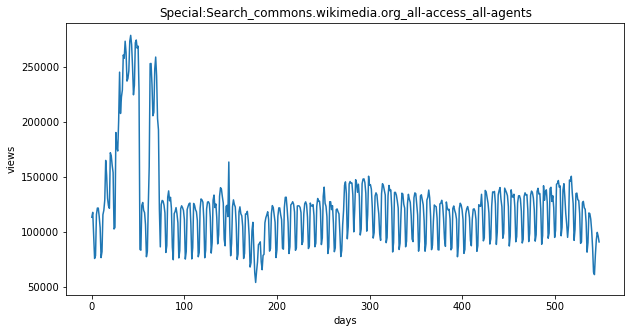

In [24]:
for key in top_pages:
    fig = plt.figure(1, figsize=(10,5))
    plt.xlabel('days')
    plt.ylabel('views')
    plt.title(data.loc[top_pages[key], 'Page'])
    
    cols = data.columns
    cols = cols[1:-2]
    df = data.loc[top_pages[key], cols]
    plt.plot(days, df)
    plt.show()

In [25]:
pickle_out = open('pickle/data.pkl', 'wb')
pickle.dump(data, pickle_out)
pickle_out.close()

In [27]:
pickle_out = open('pickle/top_pages.pkl', 'wb')
pickle.dump(top_pages, pickle_out)
pickle_out.close()

In [29]:
pickle_out = open('pickle/langs.pkl', 'wb')
pickle.dump(lang_sets, pickle_out)
pickle_out.close()

## Autocorrelation

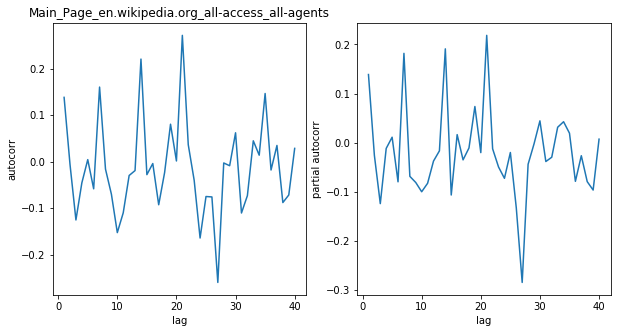

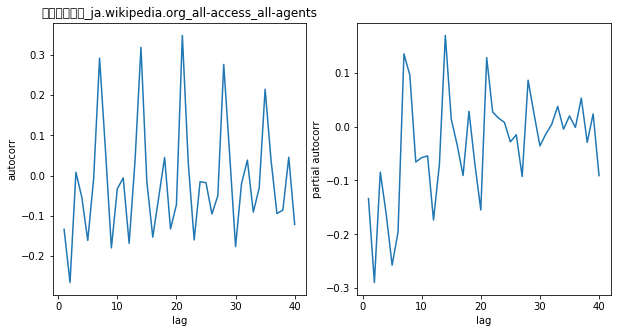

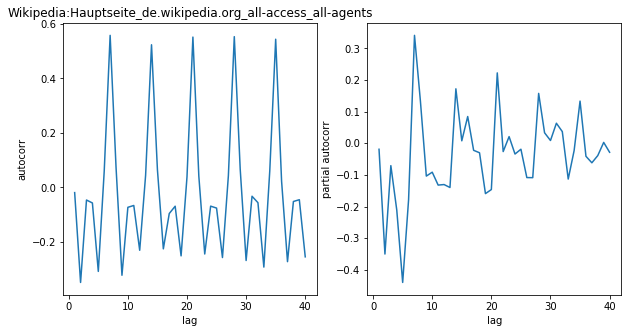

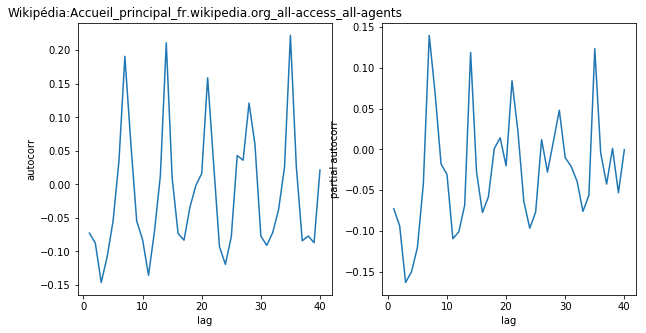

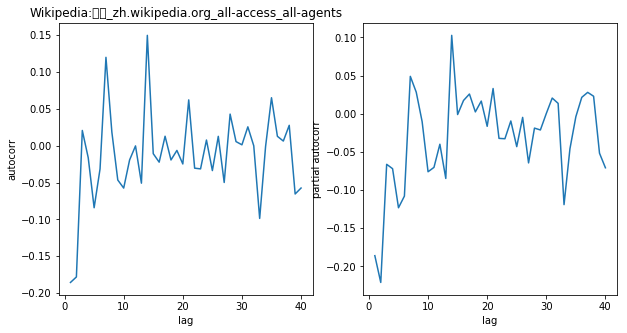

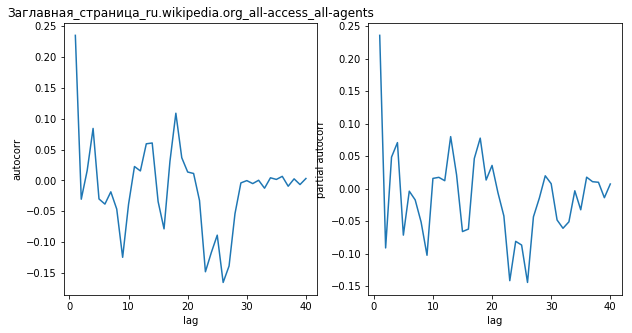

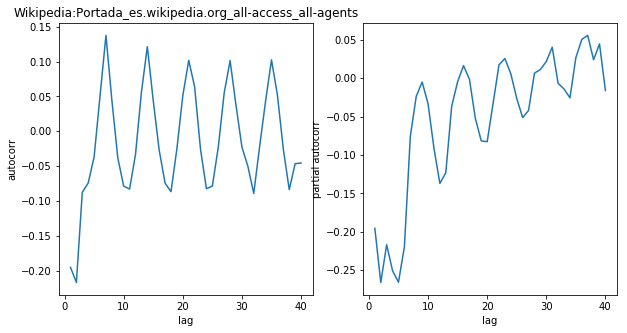

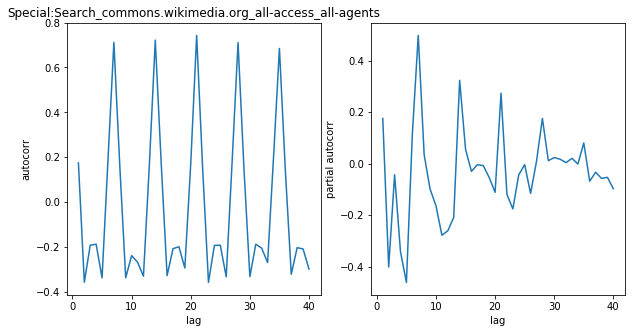

In [31]:
# autocorrelation and partial autocorrelation of top pages
for key in top_pages:
    fig = plt.figure(1, figsize=(10,5))
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    
    cols = data.columns[1:-2]
    tseries = np.array(data.loc[top_pages[key], cols])
    tseries_diff = [tseries[i] - tseries[i-1] for i in range(1, len(tseries))]
    
    autocorr = acf(tseries_diff)
    pautocorr = pacf(tseries_diff)
    
    x = [x for x in range(len(pautocorr))]
    ax1.plot(x[1:], autocorr[1:])
    ax1.set_xlabel('lag')
    ax1.set_ylabel('autocorr')
    ax1.set_title(data.loc[top_pages[key], 'Page'])
    
    ax2.plot(x[1:], pautocorr[1:])
    ax2.set_xlabel('lag')
    ax2.set_ylabel('partial autocorr')
    plt.show()

## ARIMA

In [4]:
data = pickle.load(open('pickle/data.pkl', 'rb'))
top_pages = pickle.load(open('pickle/top_pages.pkl', 'rb'))
lang_sets = pickle.load(open('pickle/langs.pkl', 'rb'))

In [9]:
cols = data.columns[1:-2]
for key in top_pages:
    tseries = np.array(data.loc[top_pages[key], cols], 'f')
    result = None
    arima = ARIMA(data,[2,1,4])
    result = arima.fit(disp=True)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        try:
            arima = ARIMA(data,[2,1,4])
            result = arima.fit(disp=True)
            print(6)
        except:
            try:
                print(3)
                arima = ARIMA(data,[2,1,2])
                result = arima.fit(disp=False)
            except:
                print(data.loc[top_pages[key],'Page'])
                print('\tARIMA failed')
    print(4)
    pred = arima.predict(2599, typ='levels')
    print(5)
    x = [i for i in range(600)]
    i=0
    
    plt.plot(x[2:len(tseries)], data[2:], label='Data')
    plt.plot(x[2:len(tseries)], pred, label='ARIMA')
    plt.title(data.loc[top_pages[key], 'Page'])
    plt.xlabel('days')
    plt.ylabel('views')
    plt.legend()
    plt.show()

MemoryError: 